# 0. 분석모듈 불러오기

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. 일단위 발전량 예측모델링

### 1-1. 월단위 발전량 데이터 불러오기 및 확인

In [2]:
data_Hourly = pd.read_csv('DaeYeon_Hourly.csv')

In [3]:
data_Hourly.head(17)

date  power  no
0   2016-01-15 05      0   1
1   2016-01-15 06      0   2
2   2016-01-15 07      0   3
3   2016-01-15 08     14   4
4   2016-01-15 09     58   5
5   2016-01-15 10    149   6
6   2016-01-15 11    215   7
7   2016-01-15 12    169   8
8   2016-01-15 13    245   9
9   2016-01-15 14    235  10
10  2016-01-15 15    130  11
11  2016-01-15 16     51  12
12  2016-01-15 17      8  13
13  2016-01-15 18      0  14
14  2016-01-15 19      0  15
15  2016-01-15 20      0  16
16  2016-01-15 21      0  17

### 1-2. 모델 적용 시차 식별(ACF, PACF)

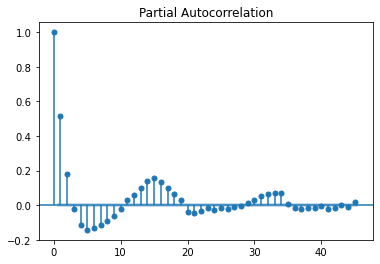

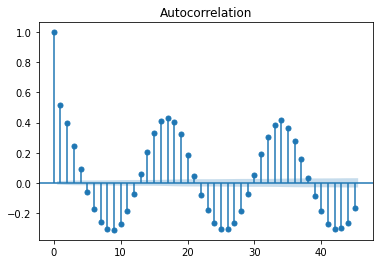

In [4]:
plot_pacf(data_Hourly['power']);
plot_acf(data_Hourly['power']);

### 1-3. 추세여부(정상성) 검정: ADF 검정

In [5]:
ad_fuller_result = adfuller(data_Hourly['power'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -15.06524877988155
p-value: 8.884916018504048e-28


### 1-4. 모델링 함수 설정

In [6]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

### 1-5. 모델 시차 적용: SARIMA(p,d,q)(P,D,Q)12

In [7]:
best_model = SARIMAX(data_Hourly['power'], order=(1, 0, 1), seasonal_order=(0, 1, 1, 17)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              power   No. Observations:                29371
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 17)   Log Likelihood             -191588.784
Date:                            Fri, 13 Nov 2020   AIC                         383185.568
Time:                                    13:13:45   BIC                         383218.717
Sample:                                         0   HQIC                        383196.215
                                          - 29371                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6607      0.009     75.404      0.000       0.644       0.678
ma.L1         -0.4151      0.009   

### 1-6 잔차 확인: 모델 수정여부 탐색

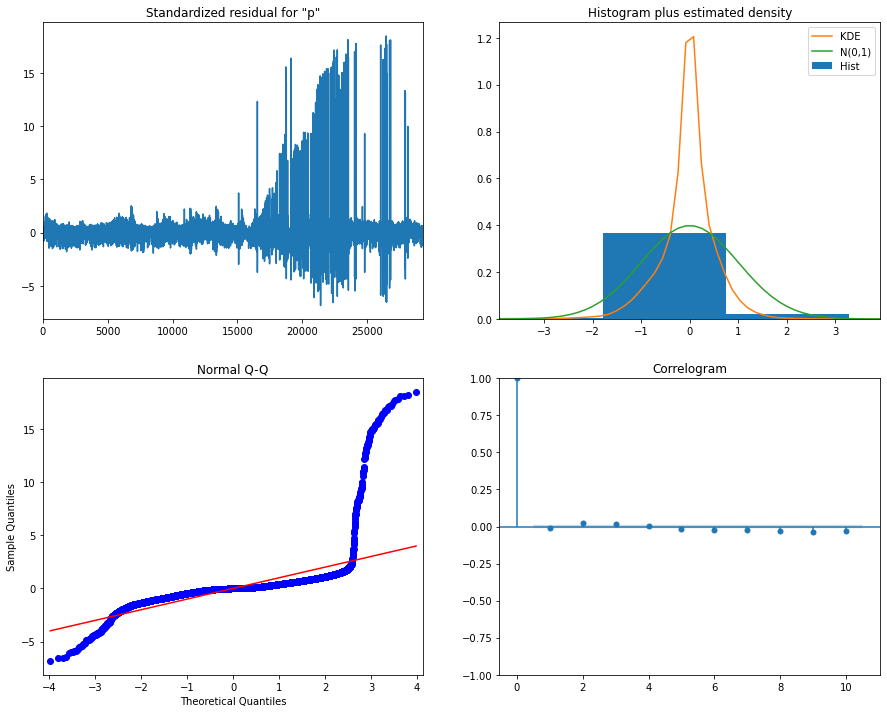

In [8]:
best_model.plot_diagnostics(figsize=(15,12));

### 1-7. 발전량 실제치-예측치 도표 확인
##### 향후 1일(17시간) 이후 예측 도표 추가

- 현재는 시간별 발전량의 이상치가 상당히 많아 별로 이상하게 나타남

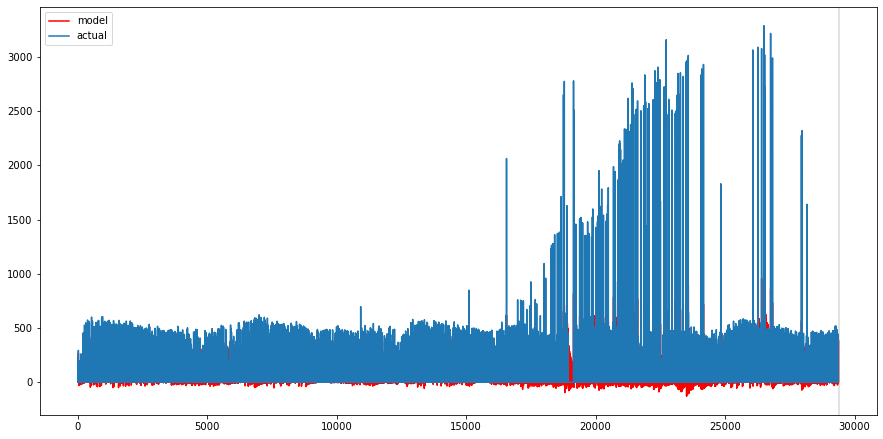

In [9]:
data_Hourly['arima_model'] = best_model.fittedvalues
data_Hourly['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=data_Hourly.shape[0], end=data_Hourly.shape[0] + 17)
forecast = data_Hourly['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data_Hourly.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data_Hourly['power'], label='actual')
plt.legend()
plt.show()

#### 내일(17 시간: 05시~21시) 발전량 예측치 계산 및 출력

In [10]:
forecast = best_model.predict(start=data_Hourly.shape[0], end=data_Hourly.shape[0] + 17)

In [11]:
forecast

29371    316.338823
29372    325.757273
29373    285.994822
29374    224.380185
29375    128.107406
29376     30.253986
29377     -3.936057
29378     -3.202144
29379     -2.344154
29380     -1.666437
29381     -0.706421
29382      0.525100
29383     50.934412
29384    166.945764
29385    263.681035
29386    336.476493
29387    366.730319
29388    380.255595
Name: predicted_mean, dtype: float64